# Daibetes Prediction
### Madhan Jeganathan
### November 14, 2024

In this project, I explore the Pima Indians Diabetes Database (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) and train classification models to predict whether or not patients have diabetes. After exploring the data, I preprocess the data with steps such as missing value imputation and feature standardization. I train and evaluate multiple classification models, including Logistic Regression, K-Nearest Neighbors, Random Forest, Support Vector Machines, and XGBoost, using grid search and cross-validation to optimize hyperparameters.

## Data Description

In [22]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [5]:
# read the dataset into a dataframe
df = pd.read_csv("data/diabetes.csv")

In [6]:
# view shape of data
df.shape

(768, 9)

In [7]:
# view column info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


It seems like there are no missing values. However, this could be misleading. Let's take a closer look.

In [8]:
# view first few rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


There are no NaN values, but several columns contains 0s where they do not make sense in context. The only feature column in which 0 would be a valid data point is the `Pregnancies` column. Let's replace the 0s in the rest of the feature columns with NaN so they show up as missing values.

In [9]:
# define feature columns
feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# define target column
target_col = ['Outcome']

df[[col for col in feature_cols if col != 'Pregnancies']] = df[[col for col in feature_cols if col != 'Pregnancies']].replace(0, np.NaN)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


Now we can view missing values by column.

In [23]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [11]:
# view column statistics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Exploratory Data Analysis (EDA)

In [12]:
# view percent of columns in which subjects have diabetes 
df[target_col].value_counts()/len(df)

Outcome
0          0.651042
1          0.348958
Name: count, dtype: float64

65% of subjects in dataset do not have diabetes while the other 35% do.

Let's view the distribution of each feature.

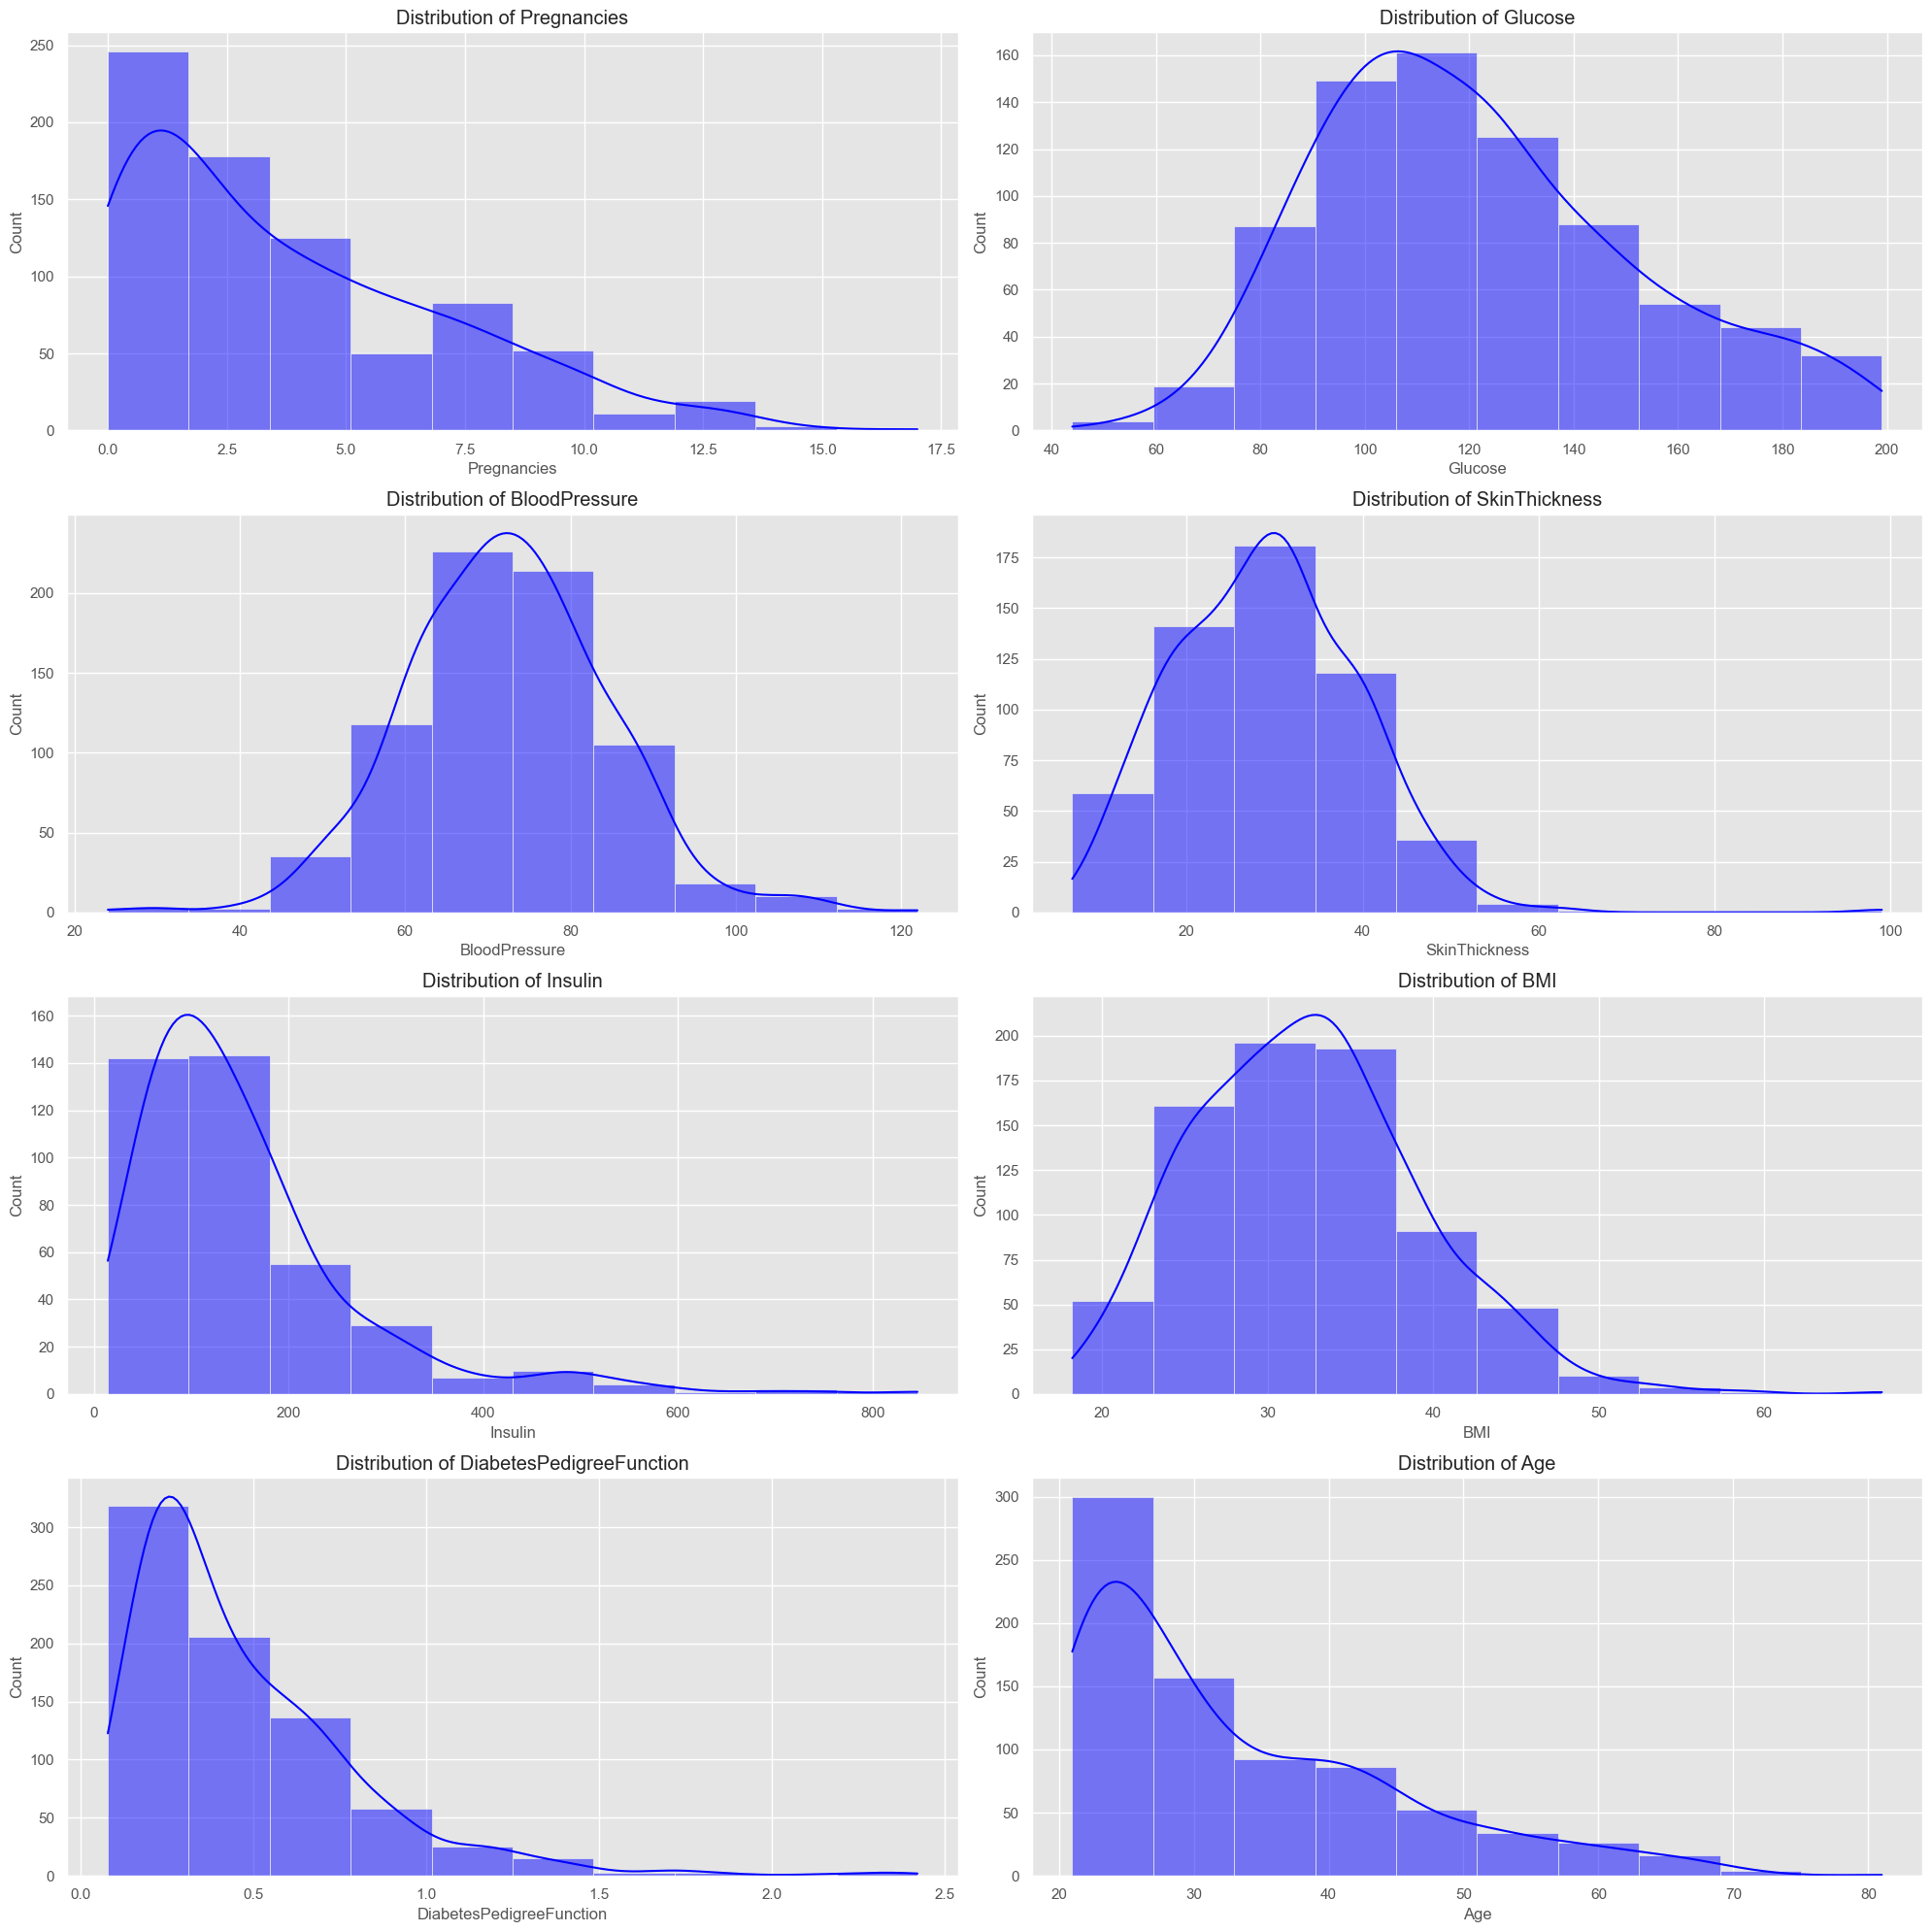

In [13]:
# create the figure and axes
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# loop through columns and axes
for i, col in enumerate(feature_cols):
    sns.histplot(df[col], bins=10, ax=ax[i // 2, i % 2], color="blue", kde=True)
    ax[i // 2, i % 2].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Now let's separate by `Outcome` and view feature distributions again.

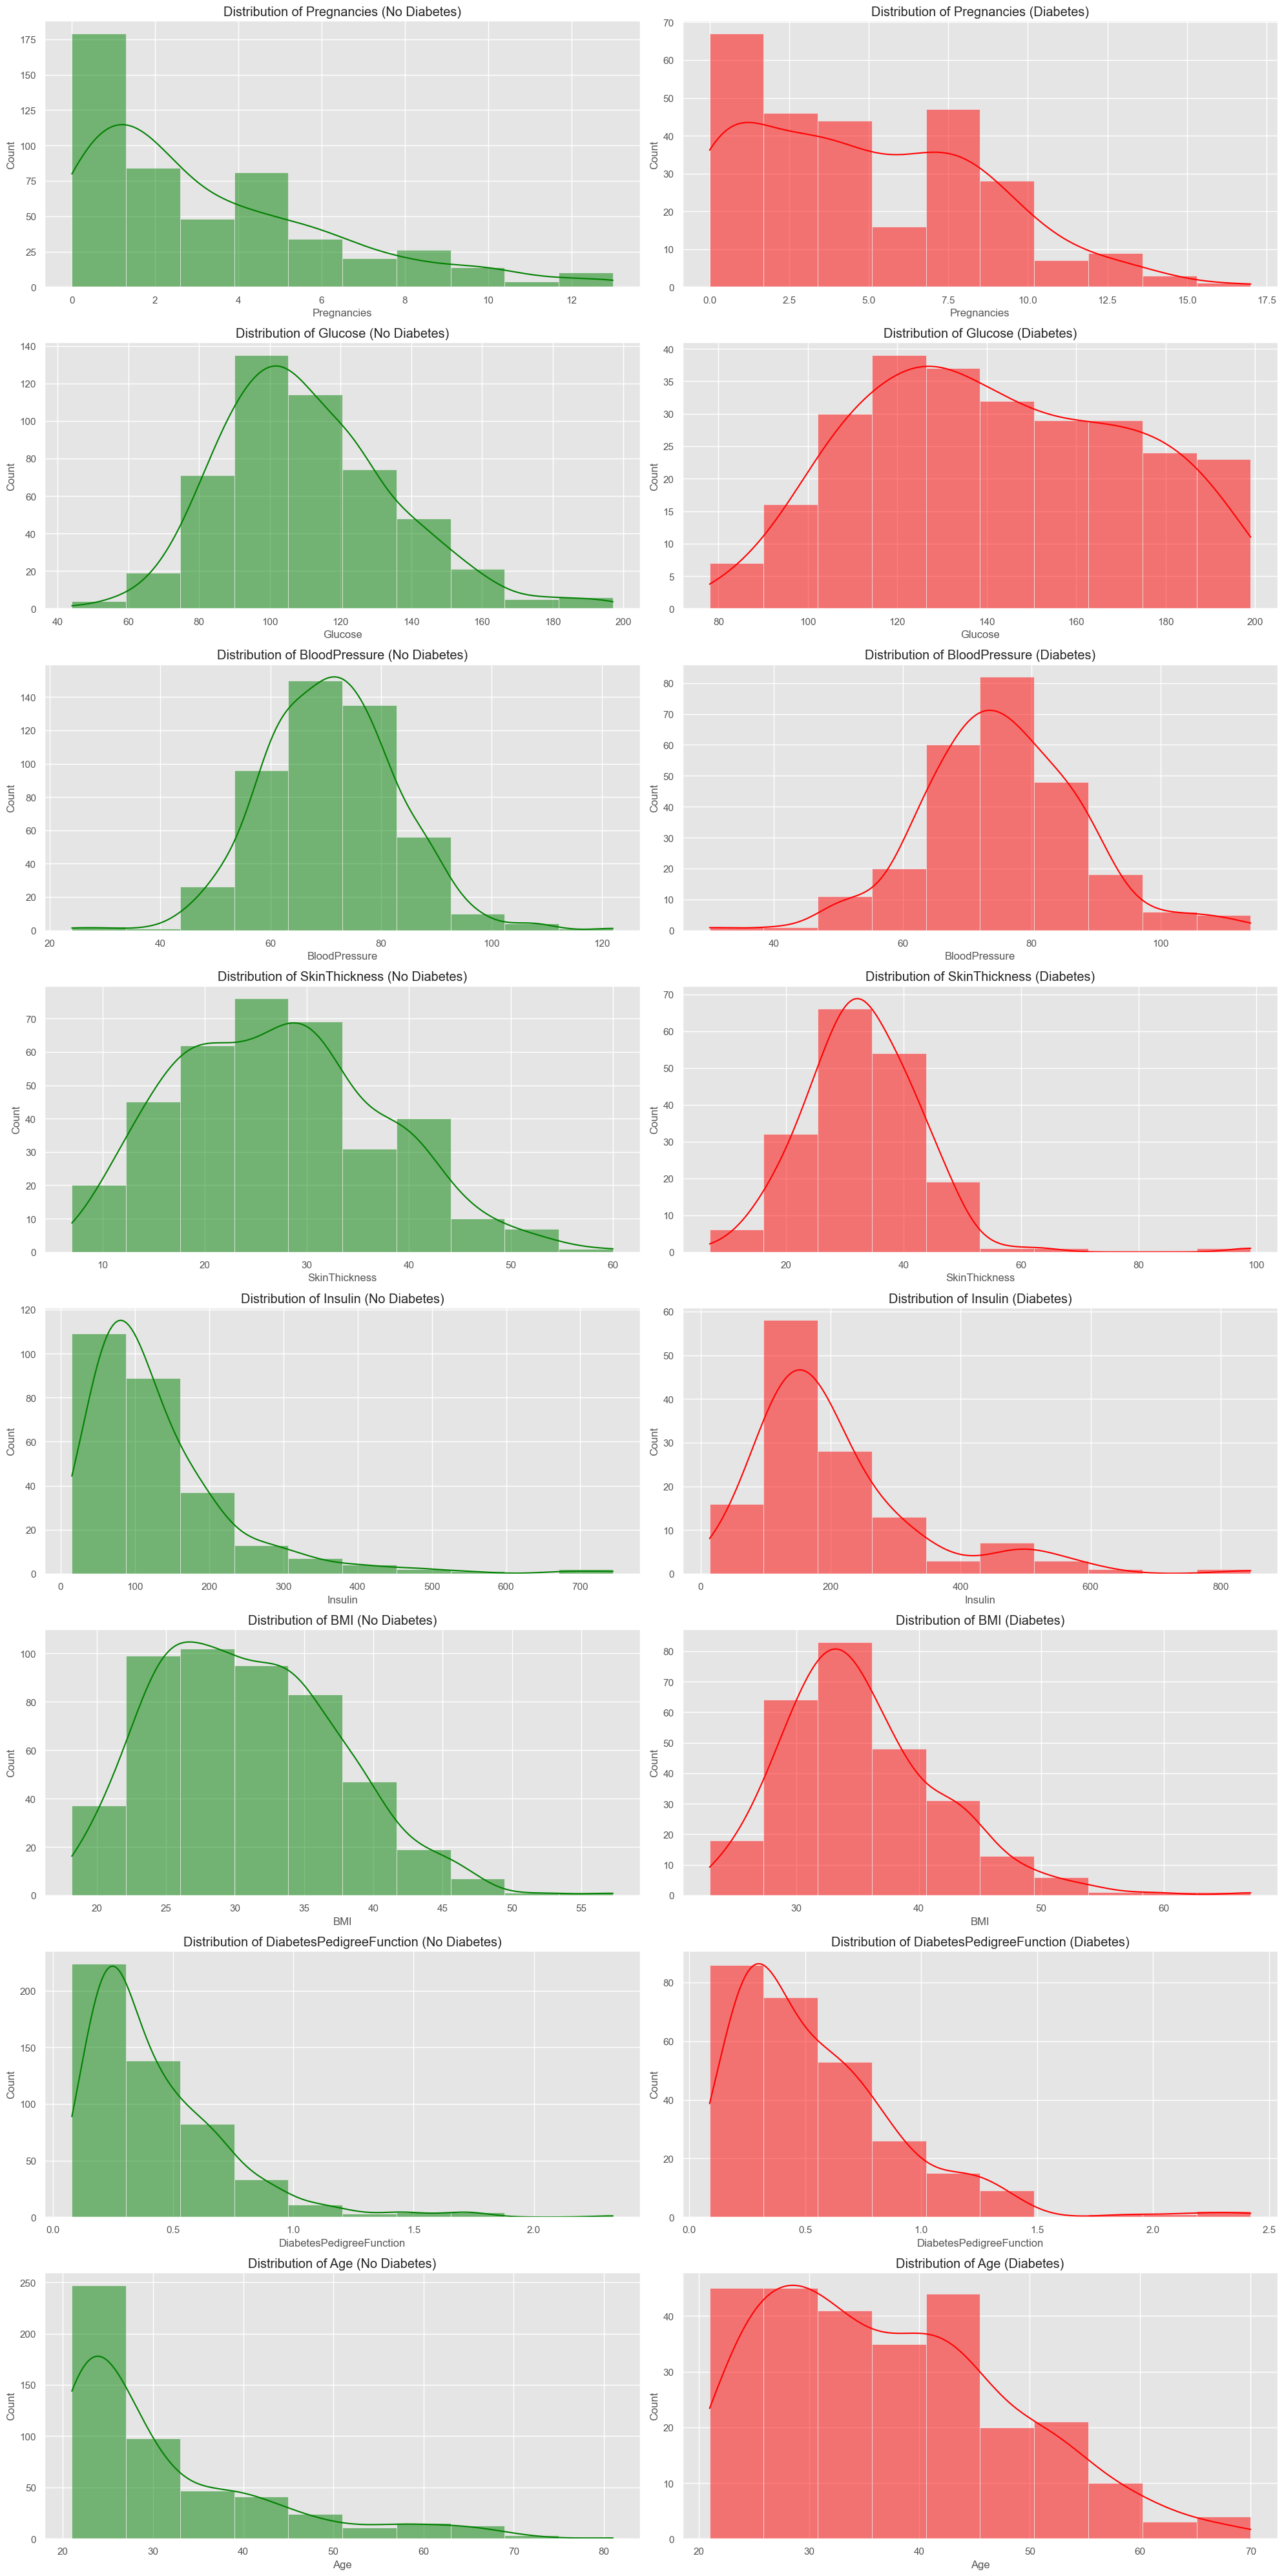

In [14]:
# Create the figure and axes
fig, ax = plt.subplots(8, 2, figsize=(20, 40))

# Loop through columns and axes
for i, col in enumerate(feature_cols):
    sns.histplot(df[col][df['Outcome']==0], bins=10, ax=ax[i, 0], color="green", kde=True)
    ax[i , 0].set_title(f'Distribution of {col} (No Diabetes)')

    sns.histplot(df[col][df['Outcome']==1], bins=10, ax=ax[i, 1], color="red", kde=True)
    ax[i , 1].set_title(f'Distribution of {col} (Diabetes)')

plt.tight_layout()
plt.show()

Let's view mean, min, and max values for features separated by `Outcome`.

In [102]:
df.groupby("Outcome").agg('mean')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


In [103]:
df.groupby("Outcome").agg('min')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,0,44.0,24.0,7.0,15.0,18.2,0.078,21
1,0,78.0,30.0,7.0,14.0,22.9,0.088,21


In [104]:
df.groupby("Outcome").agg('max')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,13,197.0,122.0,60.0,744.0,57.3,2.329,81
1,17,199.0,114.0,99.0,846.0,67.1,2.420,70


Let's create a pairplot, correlation matrix, and heatmap to get an idea of how features interact with one another.

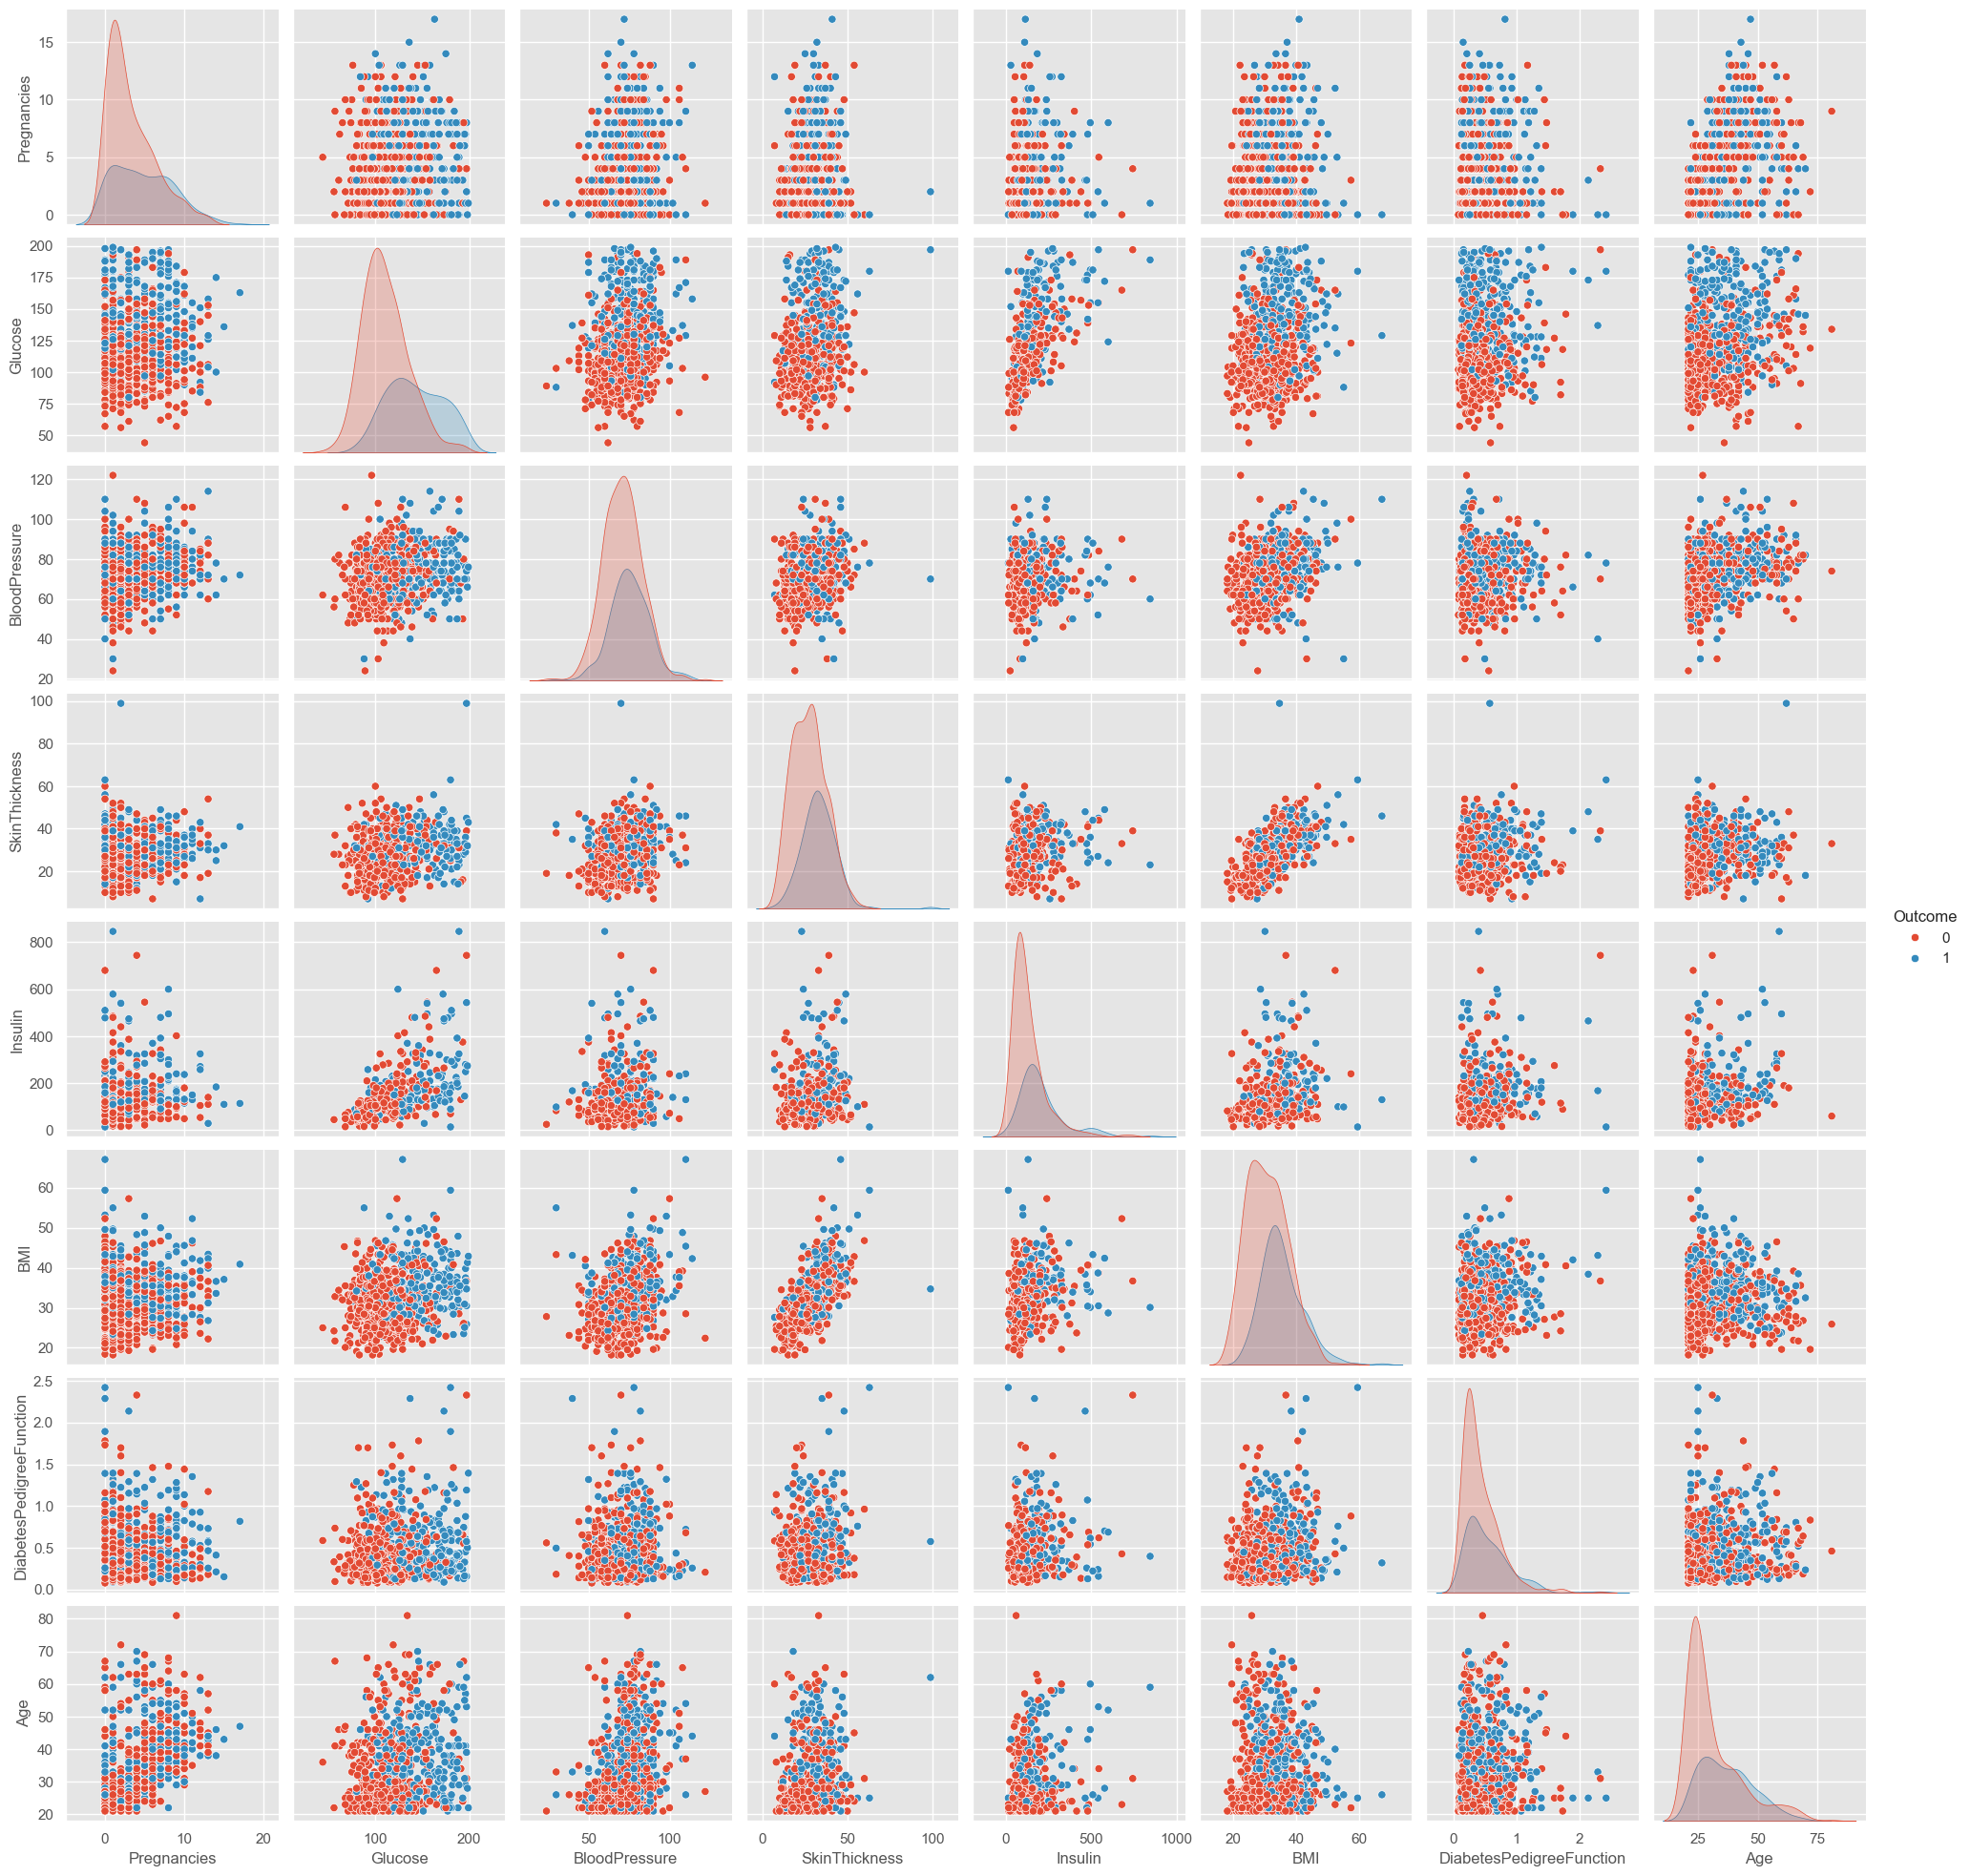

In [105]:
sns.pairplot(df, hue="Outcome")
plt.show()

In [106]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
Glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


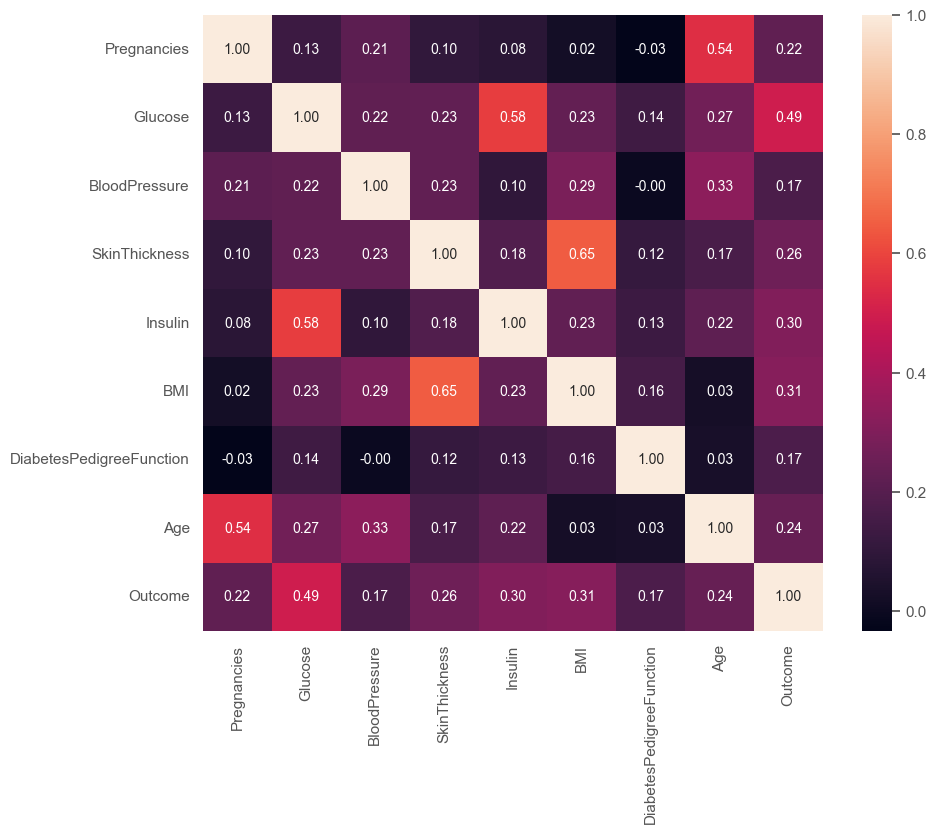

In [107]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt = '.2f')
plt.show()

## Data Preprocessing

First, let's impute missing values. We will do this by replace the missing values in a column with the mean value in that column.

In [18]:
# impute missing values by mean
df_imputed = df.fillna(df.mean())
df_imputed.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


Let's view missing values again and make sure there are none.

In [19]:
df_imputed.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [113]:
features = df_imputed[feature_cols]
target = df_imputed['Outcome']
features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.000000,148.830678,33.6,0.627,50
1,1,85.0,66.0,29.000000,148.830678,26.6,0.351,31
2,8,183.0,64.0,29.134628,148.830678,23.3,0.672,32
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33


In [114]:
target.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

Let's split the data into train and test sets and then scale values, making sure all feature columns are standardized.

In [172]:
X_train, X_test, y_train , y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Fitting

Let's train a few base classification models and evaluate them.

In [144]:
# Initialize models, including XGBoost
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb_model = xgb.XGBClassifier()

# Create a list of models
models = [log_reg, knn, svc, dtree, rf, xgb_model]

# Train each model
for model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}\n")
    print(f"Accuracy: {accuracy}\n")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", matrix)
    print("-" * 100)

Model: LogisticRegression

Accuracy: 0.7532467532467533

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154

Confusion Matrix:
 [[82 17]
 [21 34]]
----------------------------------------------------------------------------------------------------
Model: KNeighborsClassifier

Accuracy: 0.7532467532467533

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.76      0.80        99
           1       0.63      0.75      0.68        55

    accuracy                           0.75       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.75      0.76       154

Confusion Matrix:
 [[75 24]
 [14 41]]
-----

Let's see if we can improve these numbers by tuning hyperparameters.

In [175]:
# Hyperparameters to tune
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l2']
}

# Set up GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')

# Fit the model
grid_search_lr.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search_lr.best_params_)
print("Best cross-validation score:", grid_search_lr.best_score_)

# Evaluate on the test set
test_accuracy = grid_search_lr.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.7671331467413035
Test accuracy: 0.7662337662337663


In [178]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')

grid_search_knn.fit(X_train, y_train)

print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation score for KNN:", grid_search_knn.best_score_)

test_accuracy_knn = grid_search_knn.score(X_test, y_test)
print("Test accuracy for KNN:", test_accuracy_knn)

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best cross-validation score for KNN: 0.7704384912701586
Test accuracy for KNN: 0.7272727272727273


In [198]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [3, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 1]
}

svc = SVC()

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='accuracy')

grid_search_svc.fit(X_train, y_train)

print("Best parameters for SVC:", grid_search_svc.best_params_)
print("Best cross-validation score for SVC:", grid_search_svc.best_score_)

test_accuracy_svc = grid_search_svc.score(X_test, y_test)
print("Test accuracy for SVC:", test_accuracy_svc)

Best parameters for SVC: {'C': 0.1, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVC: 0.7638677862188459
Test accuracy for SVC: 0.7662337662337663


In [197]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 3, 4],
    'max_features': [None, 'sqrt', 'log2']
}

tree = DecisionTreeClassifier()

grid_search_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='accuracy')

grid_search_tree.fit(X_train, y_train)

print("Best parameters for Decision Tree:", grid_search_tree.best_params_)
print("Best cross-validation score for Decision Tree:", grid_search_tree.best_score_)

test_accuracy_tree = grid_search_tree.score(X_test, y_test)
print("Test accuracy for Decision Tree:", test_accuracy_tree)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15}
Best cross-validation score for Decision Tree: 0.7572570971611355
Test accuracy for Decision Tree: 0.7467532467532467


In [206]:
param_grid_rf = {
    'n_estimators': [25, 50, 75],
    'max_depth': [5, 10, 20, 30]
}

rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation score for Random Forest:", grid_search_rf.best_score_)

test_accuracy_rf = grid_search_rf.score(X_test, y_test)
print("Test accuracy for Random Forest:", test_accuracy_rf)

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 75}
Best cross-validation score for Random Forest: 0.7785152605624417
Test accuracy for Random Forest: 0.7727272727272727


In [190]:
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}


xgb_model = xgb.XGBClassifier()

grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')

grid_search_xgb.fit(X_train, y_train)

print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validation score for XGBoost:", grid_search_xgb.best_score_)

test_accuracy_xgb = grid_search_xgb.score(X_test, y_test)
print("Test accuracy for XGBoost:", test_accuracy_xgb)

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score for XGBoost: 0.7850726376116219
Test accuracy for XGBoost: 0.7402597402597403
